<a href="https://colab.research.google.com/github/KIMHYOENJUN/AI_project/blob/main/Image_Detection_for_ESG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Imports and Setup

필요한 Base modules import

In [ ]:
#@title TensorFlow 2.5 이상 버전 설치
# This Colab requires TF 2.5.
!pip install -U "tensorflow>=2.5"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 1.6 MB 54.2 MB/s 
     |████████████████████████████████| 5.8 MB 51.5 MB/s 
     |████████████████████████████████| 438 kB 74.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [ ]:
#@title 필요한 모듈 import
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## Utilities

아래의 셀을 실행하여 필요한 몇가지 유틸리티(함수)를 생성
 - 이미지를 불러오는 help method
 - TensorFlow Hub handle에 model명 mapping
 - COCO2017 Dataset에 대한 Human Keypoints가 있는 tuple 목록 → Keypoints가 있는 모델에 필요


In [ ]:
#@title Utilities methods 선언

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## 시각화 도구

- 적절하게 감지된 boxes, keypoints 및 segmentation으로 이미지를 시각화하기 위해  TensorFlow Object Detection API를 사용  
- 설치하기 위해 repository를 복제

In [ ]:
# Clone the tensorflow models repository
# Colab mount한 드라이브에 model download
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3403, done.
remote: Counting objects: 100% (3403/3403), done.
remote: Compressing objects: 100% (2830/2830), done.
remote: Total 3403 (delta 896), reused 1414 (delta 516), pack-reused 0
Receiving objects: 100% (3403/3403), 34.96 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (896/896), done.


Installing the Object Detection API
 - Colab은 Linux 환경이므로 Linux 명령어로 설치

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694828 sha256=ca88b8a45d15ec5a76bbb62b8af6d5e7128be1f24bce2ce4073bb7e37fa5bbc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-enp5qk4d/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=8a63cf8f019950661a6f0daba8e7f2a41d17b001c1dc138af1a4f5f003aaf25c
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/0



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.13 requires dill>=0.3.5.1, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.

나중에 필요한 종속성 모듈들을 import할 수 있음

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline 
# plot을 한 화면에 띄우도록 하는 명령코드

## 플로팅을 위해 레이블 맵 데이터 로드
간단히 하기 위해 Object Detection API 코드를 로드한 Repository에서 로드

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 감지 모델을 빌드하고 사전 훈련된 모델 가중치 로드
Detection Model 선택


In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


##TensorFlow Hub에서 선택한 모델 로드


In [ ]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


##이미지 로드하기

간단한 이미지로 시도

자신의 이미지로 실행방법  
- 이미지를 colab에 업로드하고 아래 셀에서 수행한 것과 같은 방식으로 로드
- 입력 이미지를 수정하고 제대로 감지되는지 확인(입력 이미지에는 여전히 3개의 채널이 있어야 함).  

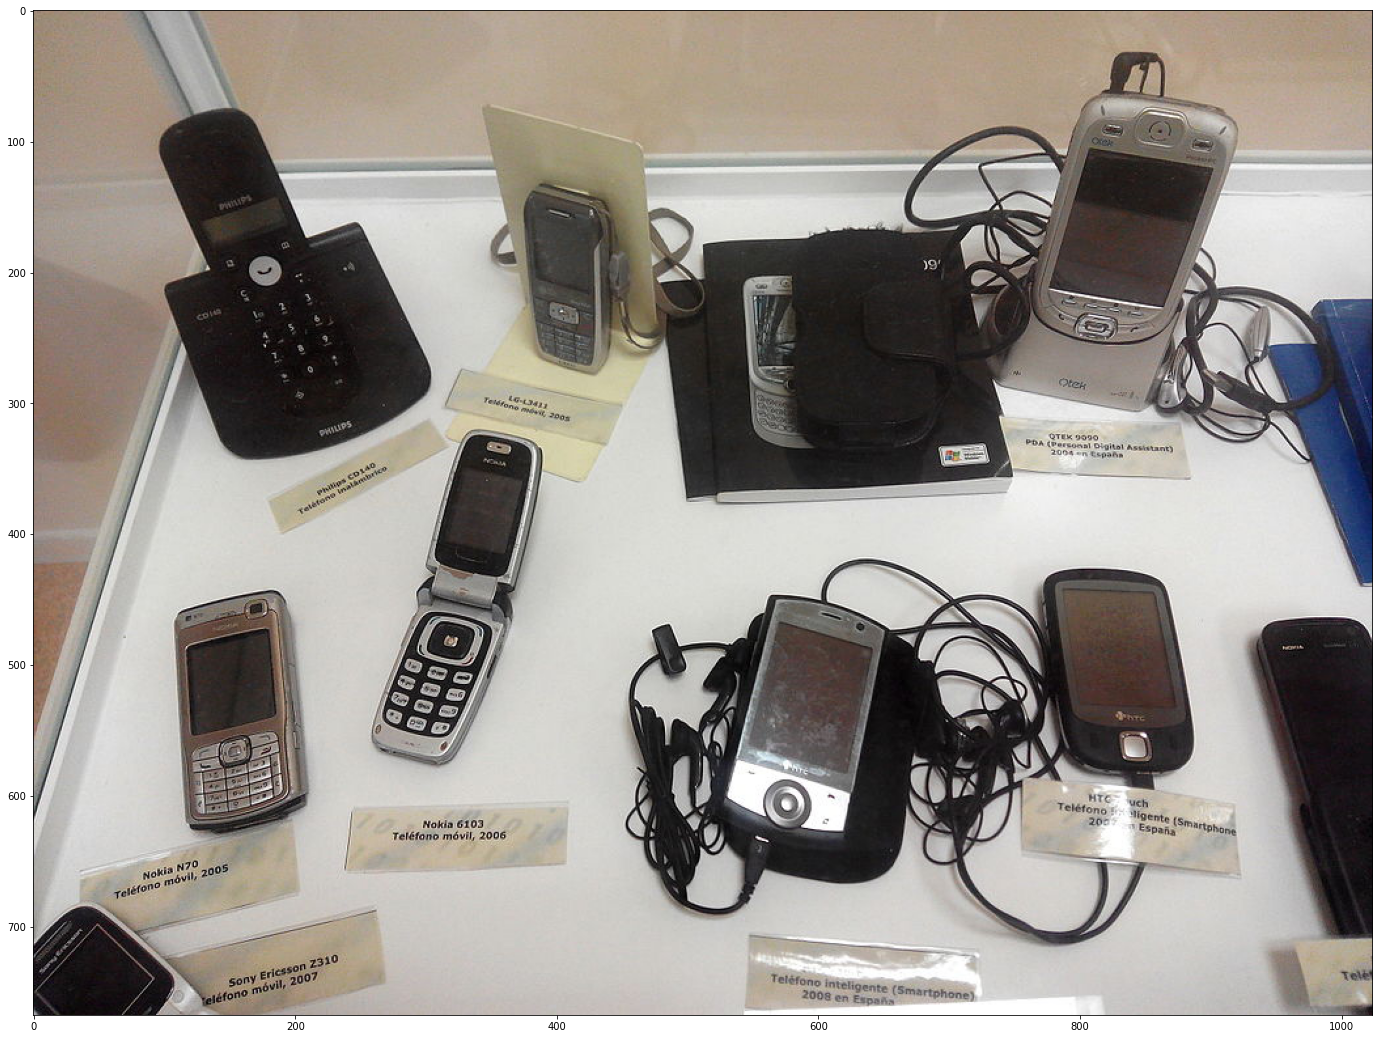

In [ ]:
#@title Image Selection (실행하는 걸 잊지 말것!) { display-mode: "form"}
selected_image = 'Phones' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

##예측

TF Hub 로드 모델 호출


In [ ]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

UnimplementedError: ignored

## 결과 시각화

예측 단계의 Bbox(및 가능한 경우 키포인트)을 표시하기 위해 TensorFlow Object Detection API를 사용

min_score_thresh를 다른 값(0과 1 사이)으로 설정하여 더 많이 감지할 수 있게 하거나 더 많은 감지를 필터링할 수 있음


In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30, # 임계값 수정으로 모델 성능 수정정
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

## 추가 기능
Mask R-CNN은 Instance Segmentation이 가능

시각화하기 위해 이전에 했던 것과 같은 방법을 사용하지만 다른 매개변수를 추가  
`instance_masks=output_dict.get('detection_masks_reframed', None)`


In [ ]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()